/Users/yangrenqin/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:100: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[  1.   1.  13.  14.  15.  16.  17.  18.  18.  19.  20.  20.  21.  21.  22.
  22.  23.  23.  23.  24.]


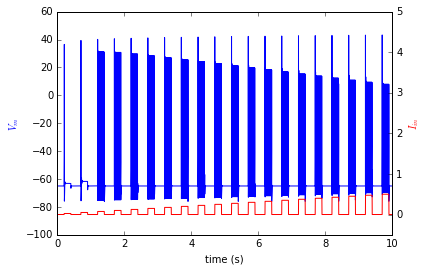

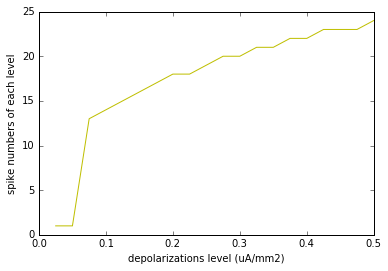

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def hh(I, dt):
    ##########################################################################
    # Simulate the membrane potential of a Hodgkin Huxley neuron with 
    #   a given input current
    # Input:
    #    I = current in uA/mm^2a
    #    dt = time step between I measurments [ms]
    #
    # Output:
    #    Vm = membrane voltage in mV
    #    n = sodium activation
    #    m = potassium activation
    #    h = 1 - potassium inactivation
    
    # This function simulates a dynamical system with state variables
    #    DV = 1/C (I - Ik - Ina - Il)
    #    Il = gl(V-El)
    #    Ik = gk*n^4(V-Ek)
    #    Ina = gna*m^3*h(V-Ena)
    #    Dn = (ninf(V) - n)/taun(V) (same for m, h )

    # Summary of units: I = uA / mm^2; V = mV; g = mS; g*V = uA; C = uF; uA/uC*ms = mV

    ##########################################################################
    # Constants:
    # Reversal potentials for various ions
    Ek = -77 #[mV]
    Ena = 50 #[mV]
    El = -54.402 #[mV]

    # Membrane capacitance: 
    C = 0.01 #[uF/mm^2]
    
    # Maximum conductances [mS/mm^2]
    gna = 1.2
    gk = 0.36
    gl = 0.003

    ##########################################################################
    # Gating variables:
    # activation K [n]
    alpha_n = lambda V: 0.01*(V + 55) / (1 - np.exp(-0.1*(V + 55)))
    beta_n = lambda V: 0.125 * np.exp(-0.0125*(V + 65))
    tau_n = lambda V: 1 /(alpha_n(V) + beta_n(V))
    n_inf = lambda V: alpha_n(V) * tau_n(V)
    # activation Na [m]
    alpha_m = lambda V: 0.1*(V + 40) / (1 - np.exp(-0.1*(V + 40)))
    beta_m = lambda V: 4 * np.exp(-0.0556*(V + 65))
    tau_m = lambda V: 1/(alpha_m(V) + beta_m(V))
    m_inf = lambda V: alpha_m(V) * tau_m(V)
    # inactivation Na [h]
    alpha_h = lambda V: 0.07*np.exp(-0.05*(V + 65))
    beta_h = lambda V:  1 /(1 + np.exp(-0.1*(V + 35)))
    tau_h = lambda V: 1/(alpha_h(V) + beta_h(V))
    h_inf = lambda V: alpha_h(V) * tau_h(V);
    
    # Initializations
    n = np.zeros(len(I)); m = np.zeros(len(I)); h = np.zeros(len(I)); V = np.zeros(len(I))
 
    # Set initial conditions:
    Vstart = -65 #[mV] (starting membrane potential) 
    V[0] = Vstart #[mV]
    n[0] = n_inf(Vstart); m[0] = m_inf(Vstart); h[0] = h_inf(Vstart);
    
    ##########################################################################
    # Simulation: iteratatively update the variables using the forward Euler method
    for ii in range(len(I)-1):
        # Update activation state variables
        n[ii+1] = n[ii] + dt*(n_inf(V[ii]) - n[ii])/tau_n(V[ii])
        m[ii+1] = m[ii] + dt*(m_inf(V[ii]) - m[ii])/tau_m(V[ii])
        h[ii+1] = h[ii] + dt*(h_inf(V[ii]) - h[ii])/tau_h(V[ii])
        V[ii+1] = V[ii] + dt/C*(I[ii] - gl*(V[ii]-El) - gk*n[ii]**4 *(V[ii]-Ek) - gna*m[ii]**3*h[ii]*(V[ii]-Ena));

    return V, m, n, h

def get_aps(V):
    V_ap=[]
    for i in range(len(V)-1):
        if V[i]>0:
            V_ap.append(V[i])
    ap=0
    for i in range(len(V_ap)-1):
        if V_ap[i+1]-V_ap[i]>=0 and V_ap[i+2]-V_ap[i+1]<=0:
            ap +=1
    return ap

input_I = np.arange(0.025,0.525,0.025)
dt=0.01
I = np.zeros(int(10000/dt))
for i in range (20):
    I[int((i*500+200)/dt):int((i*500+400)/dt)]=input_I[i]


V,m,m,h = hh(I,dt)
ap_numbers=np.zeros(20)
for i in range(20):
    ap_numbers[i]=get_aps(V[int((i*500))/dt:int((i*500+499)/dt)])
print(ap_numbers)
%matplotlib inline
fig, ax1 = plt.subplots()
t = np.arange(0, 10, dt / 1000)
ax1.plot(t, V, 'b-')
ax1.set_xlabel('time (s)')
ax1.set_ylabel(r'$V_{m}$', color='b')
ax1.set_ylim([-100, 60])
ax2 = ax1.twinx()
ax2.plot(t, I, 'r-')
ax2.set_ylim([-0.5, 5])
ax2.set_ylabel(r'$I_{in}$', color='r')

fig, ax3 = plt.subplots()
ax3.plot(input_I,ap_numbers,'y')
ax3.set_xlabel('depolarizations level (uA/mm2)')
ax3.set_ylabel('spike numbers of each level')